# Test de la class physics
Passage dans la base des vecteurs propres.

In [1]:
# importation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# local
from MyResNet.myfunc import Physics

In [2]:
a  = 1
p  = 1
nx = 20000
m  = 200
t = np.linspace(0,1,nx)

In [3]:
test = Physics(nx,m,a,p)

### Test des fonctions de base

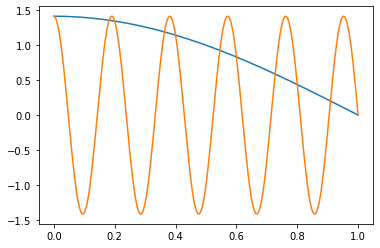

In [4]:
x0 = np.sqrt(2)*np.cos(np.pi/2*t)
xm = np.sqrt(2)*np.cos(np.pi*(10+1/2)*t)
plt.plot(t,x0)
plt.plot(t,xm)

In [5]:
y0 = test.BasisChange(x0)
ym = test.BasisChange(xm)
(y0**2).sum()

1.0000500019828813

In [6]:
(ym**2).sum()

1.0000497743919572

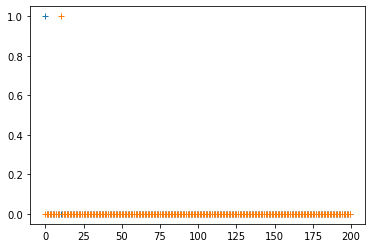

In [7]:
plt.plot(y0,'+')
plt.plot(ym,'+')

In [8]:
print('norm cosinus :',np.linalg.norm(x0)*np.sqrt(1/nx))
print('norm base cosinus :',np.linalg.norm(y0))

norm cosinus : 1.0000000000000002
norm base cosinus : 1.000025000678924


In [9]:
print('norm cosinus :',np.linalg.norm(xm)*np.sqrt(1/nx))
print('norm base cosinus :',np.linalg.norm(ym))

norm cosinus : 1.0
norm base cosinus : 1.0000248868863


### Test de la matrice test.basis

In [10]:
P   = test.basis
tP  = np.transpose(P)
Im  = np.dot(P,tP)
Inx = np.dot(tP,P)

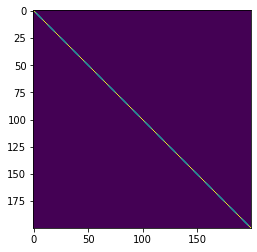

In [11]:
plt.imshow(Im)

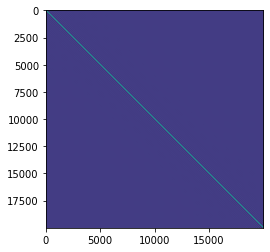

In [12]:
plt.imshow(Inx)

$P$ est une matrice de changement de base, mais pas entre des espaces de même taille.
$$
\|Pf\|_\phi^2 
= \langle ^tP Pf,\rangle 
= \langle I_{nx}f,f\rangle
$$
et
$$
\|Pf\|_\phi^2 
= \| \tilde{f}\|_\phi^2 
= \; (\text{Parceval}) \; \| f\|_{L^2}^2
= \frac{1}{nx} \sum f_i^2
$$

In [13]:
np.linalg.norm(Inx)

0.0007071227561841198

In [14]:
np.linalg.norm(Im)

0.0007071227561841227

### Test de la fonction ChangeBase et ChangeBaseInv

In [15]:
x = np.exp(-(t-0.5)**2/0.01)

In [16]:
y  = test.BasisChange(x)
x1 = test.BasisChangeInv(y)

$$
\|f\|_{L^2}^2 = \frac{1}{nx} \left(
\frac{f_0}{2}+\frac{f_{nx-1}}{2} \sum_{i=1}^{nx-2} f_i^2
\right)
$$
$$
\|\tilde{f}\|_{\phi}^2 = \sum_{i=0}^{m-1} \tilde{f}_i^2
$$
$$
\text{Parceval} \;\;
\|f\|_{L^2}^2 = \|\tilde{f}\|_{\phi}^2
\;\;
\leftrightarrow
\;\;
\left(\sum_{i=0}^{nx-1} f_i^2\right)^{1/2} 
= 
nx^{1/2}\left(\sum_{i=0}^{m-1} \tilde{f}_i^2\right)^{1/2} 
$$

In [17]:
print('norm gaussienne :',np.linalg.norm(x))
print('norm base cosinus :',np.linalg.norm(y))

norm gaussienne : 50.064987198812595
norm base cosinus : 0.3540217664497734


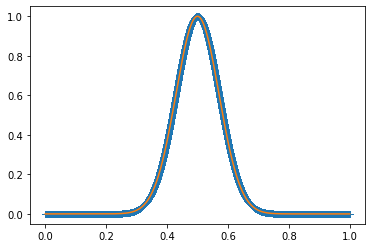

In [18]:
plt.plot(t,x,'+')
plt.plot(t,x1)

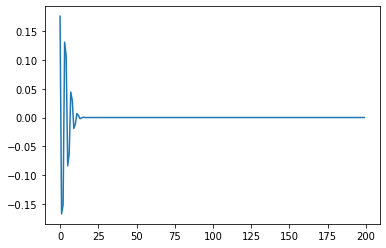

In [19]:
plt.plot(y)

### Test de la fonction Top

L' opérateur $T$ envoie les $t \to \sqrt{2} \; cos(\mu_j t)$ sur les vecteurs $t \to \sqrt{2} \frac{1}{\mu_j} \; sin(\mu_j t)$.
On doit ensuite repasser dans la base des $t \to \sqrt{2} \; cos(\mu_i t)$.

La première méthode consiste à considérer la matrice de changement de base $Q$ entre les elements finis $(e_p)$ et $t \to \sqrt{2} \; sin(\mu_j t)$ et composer avec la matrice diagonale des $(1/\mu_n)$. A noter qu'il y a surement des problèmes d'homogeneite car la norme du vecteur dans $(e_p)$ est égale à un coefficient près.

In [20]:
 # Operator T
# step 0 : Abel operator integral
eigm = (np.linspace(0,m-1,m)+1/2)*np.pi
# the image of the cos(t) basis is projected in a sin(t) basis
Tdiag      = np.diag(1/eigm)
#
h          = 1/(nx-1)
v1         = ((2*np.linspace(0,nx-1,nx)+1)*h/2).reshape(1,-1)
v2         = (np.ones(nx)/2*h).reshape(1,-1)
# step 2 : From sin(t) basis to cos(t) basis
eig_m      = eigm.reshape(-1,1)
base_sin   = np.zeros((m,nx))
base_sin   = 2*np.sqrt(2)/eig_m*np.sin(v1*eig_m)*np.sin(v2*eig_m)
base_f     = np.matmul(test.basis,base_sin.T)
# step 3 : Combinaison of Top and base change
Top = np.matmul(base_f,Tdiag)*nx

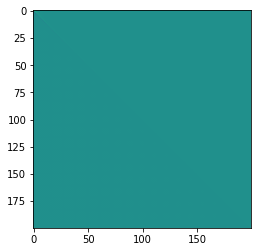

In [21]:
plt.imshow(Top)

La deuxième méthode se passe des éléments $(e_p)$, elle cacule directement la projection de $t \to \sqrt{2} \frac{1}{\mu_j} \; sin(\mu_j t)$ sur la base des cosinus (plus calculatoire mais aussi plus fiable.

In [22]:
from itertools import product
Tf = np.zeros((m,m))
for i,j in product(range(m),range(m)):
    if i==j:
        Tf[i,i]= 2/eigm[j]/((2*i+1)*np.pi)
    else:
        Tf[i,j]= 1/eigm[j]*( 1/((i+j+1)*np.pi)*(1+np.cos((i+j)*np.pi))\
                            +1/((j-i)*np.pi)*(1-np.cos((j-i)*np.pi)) )

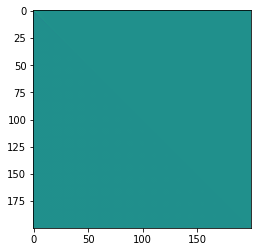

In [23]:
plt.imshow(Tf)

Comparaison

In [24]:
Topy0 = Top.dot(y0)
Tfy0  = Tf.dot(y0)

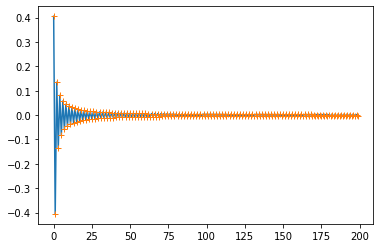

In [25]:
plt.plot(Topy0)
plt.plot(Tfy0,'+')

In [26]:
Topx0 = test.BasisChangeInv(Topy0)
Tx0 = test.BasisChangeInv(Tfy0)

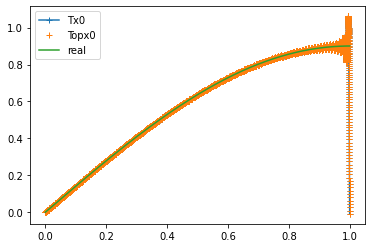

In [27]:
plt.plot(t,Tx0,'-+',label='Tx0')
plt.plot(t,Topx0,'+',label='Topx0')
plt.plot(t,np.cumsum(x0)*1/nx,label='real')
plt.legend()

In [28]:
np.linalg.norm(Top-Tf)

3.571612358063143e-05

### Et finalement test de la fonction Compute

In [29]:
Tx0 = test.Compute(x0)

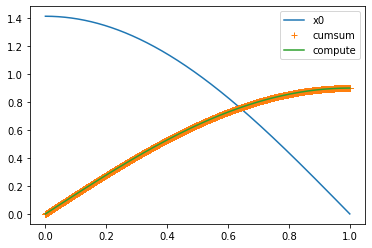

In [30]:
plt.plot(t,x0,label="x0")
plt.plot(t,np.cumsum(x0)/nx,'+',label="cumsum")
plt.plot(t,Tx0,label="compute")
plt.legend()

In [31]:
tTTx0_cos = test.ComputeAdjoint(Tx0)
tTTx0     = test.BasisChangeInv(tTTx0_cos)

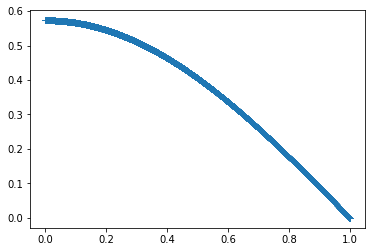

In [32]:
plt.plot(t,tTTx0/,"+")

In [35]:
1/eigm[0]

0.6366197723675814

In [34]:
tTTx0[0]

0.5732742890510913

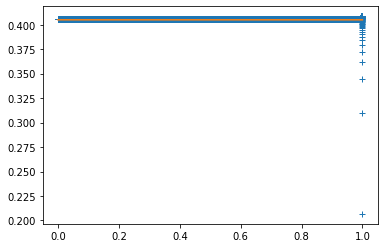

In [42]:
plt.plot(t[:-1],tTTx0[:-1]/x0[:-1],"+")
plt.plot(t,0.405*np.ones(nx))

In [44]:
1/test.eigm**2

array([4.05284735e-01, 4.50316372e-02, 1.62113894e-02, 8.27111703e-03,
       5.00351524e-03, 3.34946062e-03, 2.39813452e-03, 1.80126549e-03,
       1.40236932e-03, 1.12267239e-03, 9.19013004e-04, 7.66133714e-04,
       6.48455575e-04, 5.55946138e-04, 4.81908127e-04, 4.21732294e-04,
       3.72162291e-04, 3.30844681e-04, 2.96044364e-04, 2.66459392e-04,
       2.41097403e-04, 2.19191311e-04, 2.00140610e-04, 1.83469776e-04,
       1.68798307e-04, 1.55818814e-04, 1.44280788e-04, 1.33978425e-04,
       1.24741377e-04, 1.16427674e-04, 1.08918230e-04, 1.02112556e-04,
       9.59253810e-05, 9.02839685e-05, 8.51259682e-05, 8.03976859e-05,
       7.60526805e-05, 7.20506195e-05, 6.83563391e-05, 6.49390698e-05,
       6.17717931e-05, 5.88307061e-05, 5.60947730e-05, 5.35453474e-05,
       5.11658546e-05, 4.89415209e-05, 4.68591438e-05, 4.49068958e-05,
       4.30741561e-05, 4.13513656e-05, 3.97299024e-05, 3.82019733e-05,
       3.67605201e-05, 3.53991383e-05, 3.41120053e-05, 3.28938182e-05,
      